In [1]:
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from pprint import pprint

In [2]:
data = {}
folder_path = "logs/second_experiment"
for filename in os.listdir(folder_path):
    # Check if the file is a JSON file
    if filename.endswith(".json"):
        # Construct the full path of the file
        file_path = os.path.join(folder_path, filename)

        # Open and parse the JSON file
        with open(file_path, "r") as file:
            model_data = json.load(file)

        # Store the parsed data in a dictionary using the filename as the key
        model_name = model_data["model_name"]
        original_model_accuracy = model_data["original_model_accuracy"]
        quantization_data = {
            "error_threshold": model_data["error_threshold"],
            "quantized_model_accuracy": model_data["quantized_model_accuracy"],
            "average_bit_width": model_data["average_bit_width"],
            "min_quantile": model_data["min_quantile"],
            "max_quantile": model_data["max_quantile"],
            "layerwise_quantization_info": model_data["layerwise_quantization_info"],
        }

        # If the model name does not exist in the dictionary, add it
        if model_name not in data:
            data[model_name] = {
                "original_model_accuracy": original_model_accuracy,
                "quantization_data": [],
            }

        # Add the quantization data to the dictionary
        data[model_name]["quantization_data"].append(quantization_data)

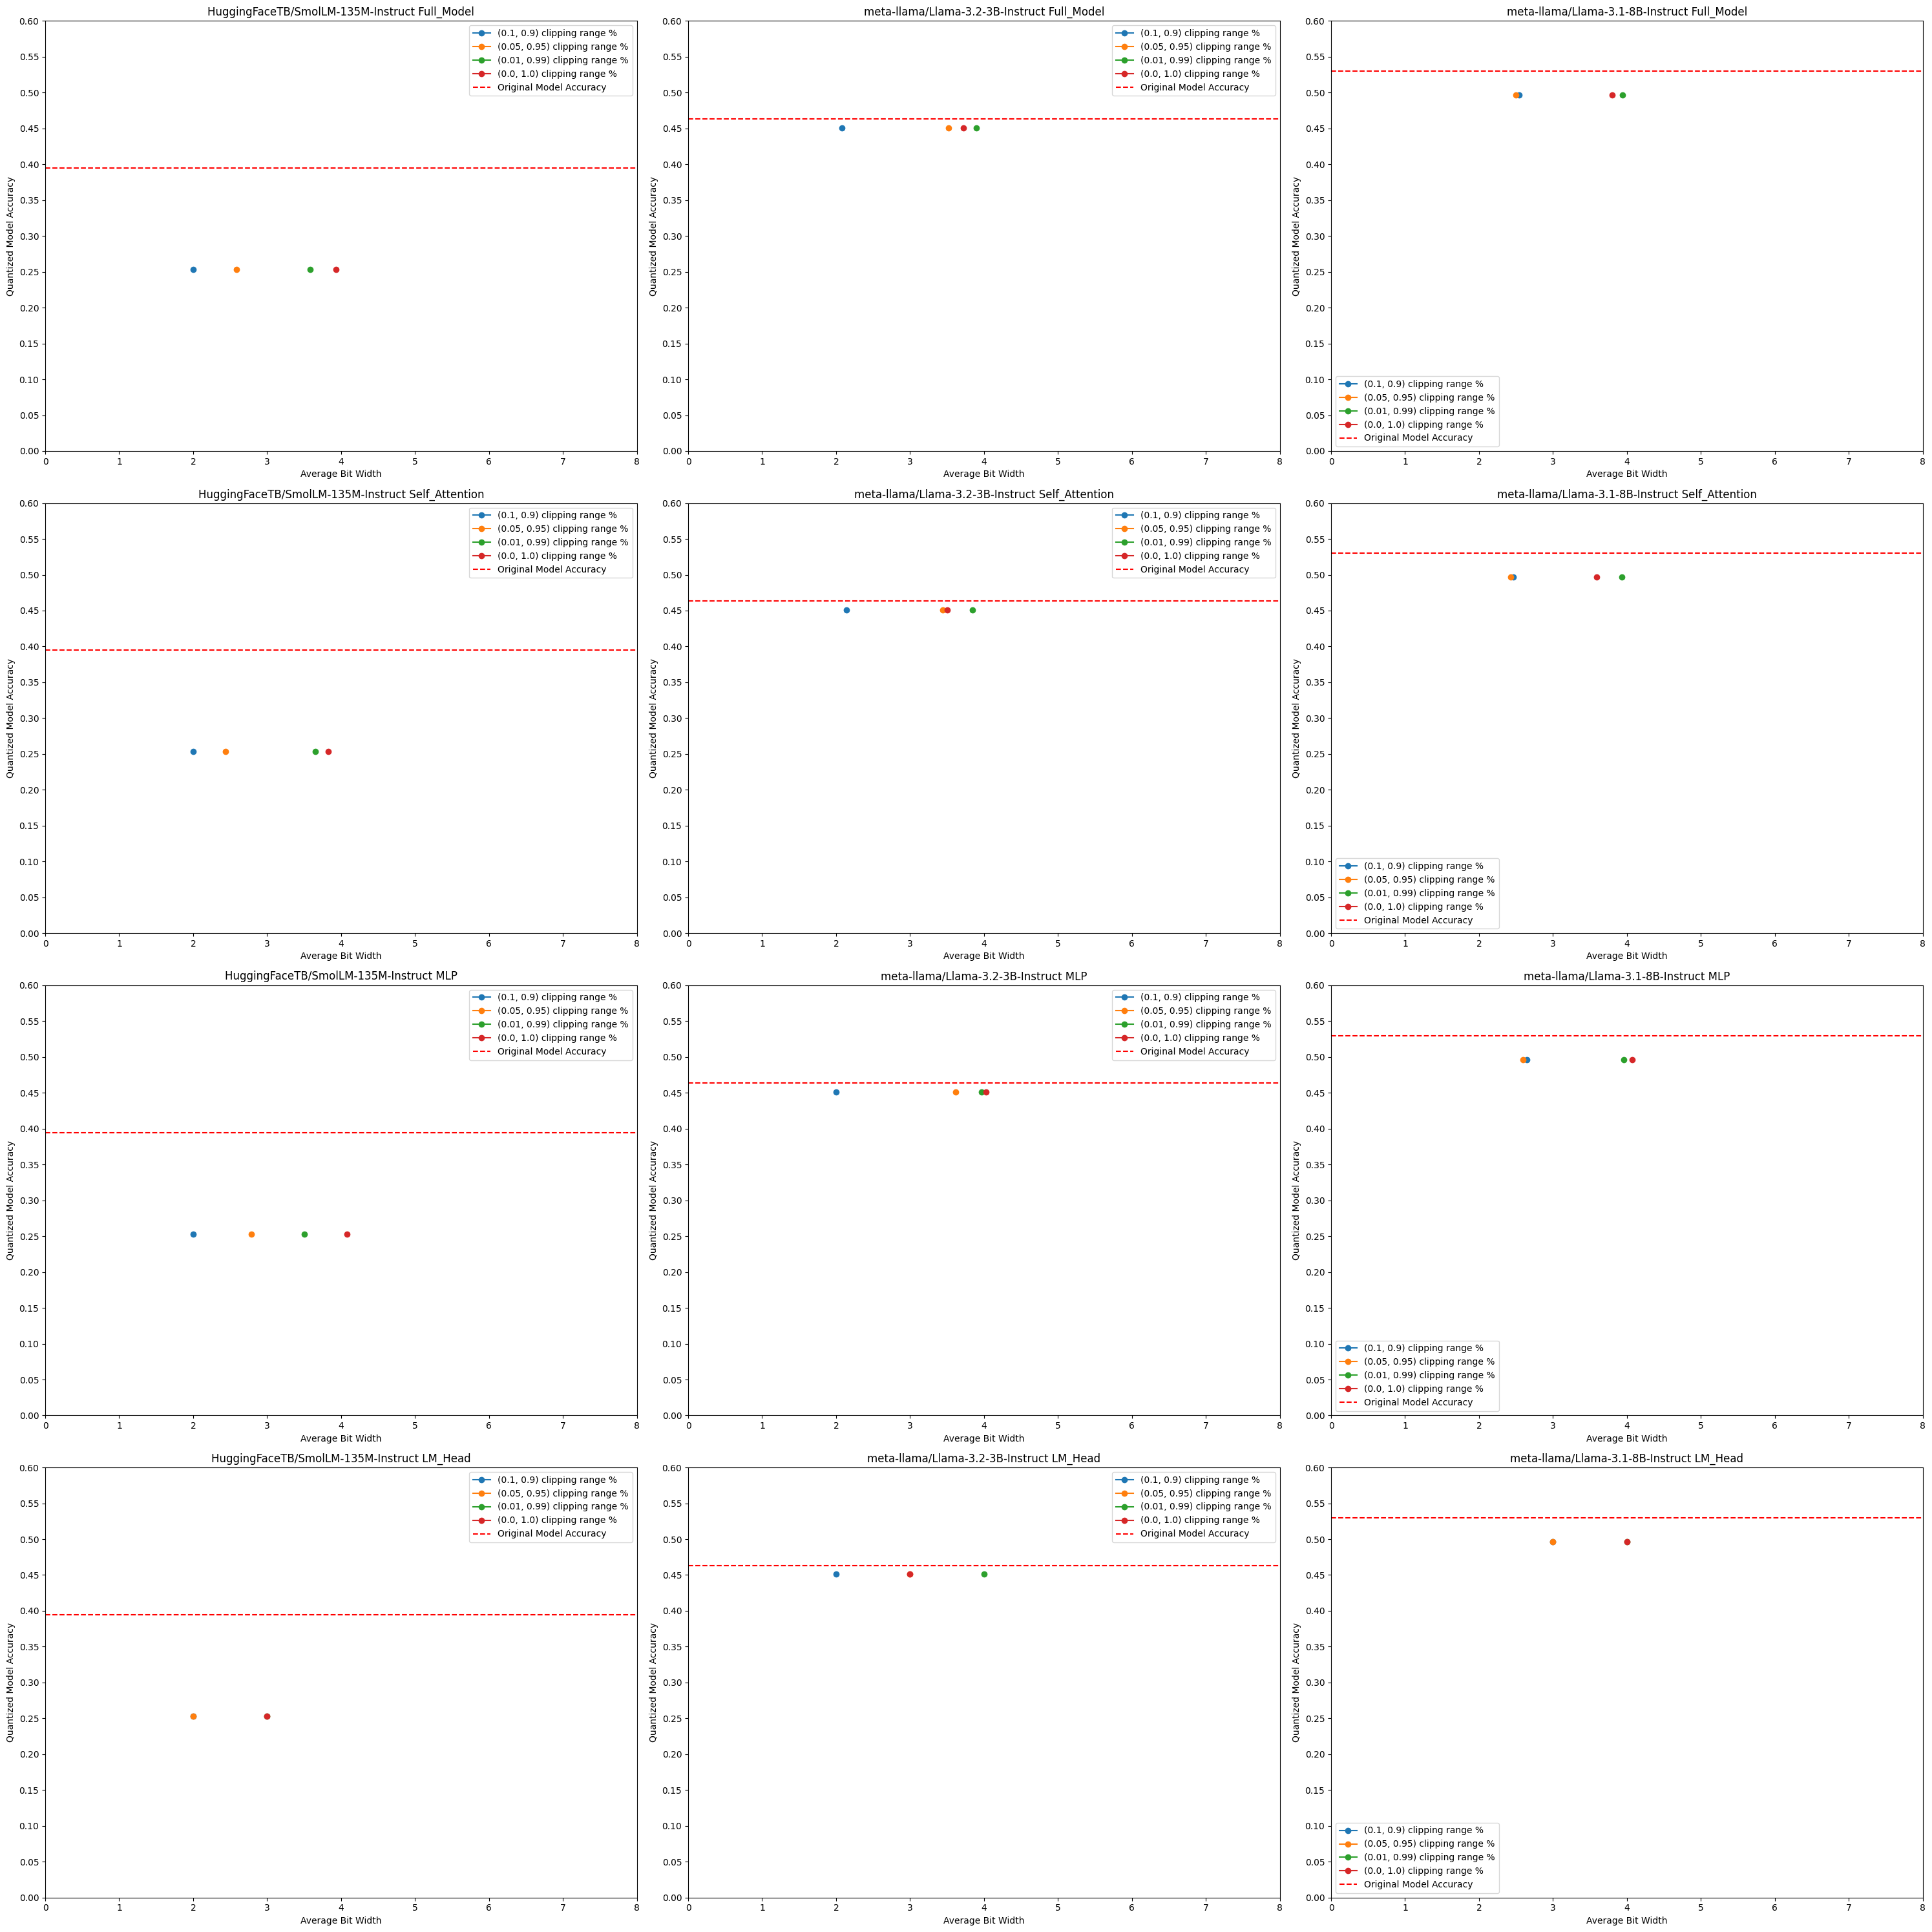

In [3]:
# Create Subplots per model
# For each quantile range [(0.0, 1.0), (0.01, 0.99), (0.05, 0.95)]
# x-axis is the sqnr dB with labels and error_threshold as value
# y-axis is the model quantized model accuracy

quantile_ranges = [(0.1, 0.9), (0.05, 0.95), (0.01, 0.99), (0.0, 1.0)]
model_components = {
    "Full_Model": "",
    "Self_Attention": "self_attn",
    "MLP": "mlp",
    "LM_Head": "lm_head",
}
fig, ax = plt.subplots(len(model_components), len(data), figsize=(30, 30))

models_in_correct_order = [
    "HuggingFaceTB/SmolLM-135M-Instruct",
    "meta-llama/Llama-3.2-3B-Instruct",
    "meta-llama/Llama-3.1-8B-Instruct",
]
# sort the models in the correct order
data = {k: data[k] for k in models_in_correct_order}
for j, (model_name, model_data) in enumerate(data.items()):
    quantization_data = model_data["quantization_data"]
    for i, (component_name, layer_name_filter) in enumerate(model_components.items()):
        original_model_accuracy = model_data["original_model_accuracy"]
        lines = []

        for k, quantile_range in enumerate(quantile_ranges):
            x = []
            y = []

            for quantization_info in quantization_data:
                if (
                    quantization_info["min_quantile"] != quantile_range[0]
                    or quantization_info["max_quantile"] != quantile_range[1]
                ):
                    continue

                len = 0
                total = 0

                for layer_name, layer_data in quantization_info[
                    "layerwise_quantization_info"
                ].items():
                    if layer_name_filter in layer_name:
                        len += 1
                        total += layer_data["bit_width"]

            quantized_model_accuracy = quantization_info["quantized_model_accuracy"]

            x.append(total / len)
            y.append(quantized_model_accuracy)

            # Sort the x and y values based on the x values
            x, y = zip(*sorted(zip(x, y)))

            # (line,) = ax[i].plot(x, y, label=f"{quantile_range} quantile range")
            # plot with markers
            (line,) = ax[i, j].plot(
                x,
                y,
                marker="o",
                label=f"{quantile_range} clipping range %",
            )
            lines.append(line)

        ax[i, j].axhline(y=original_model_accuracy, color="r", linestyle="--")
        # add horizontal line to legend
        lines.append(
            mpl.lines.Line2D(
                [0], [0], color="r", linestyle="--", label="Original Model Accuracy"
            )
        )

        # use 0 to .60 on y axis in steps of 0.05
        ax[i, j].yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.05))
        ax[i, j].xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
        # set axis limits
        ax[i, j].set_ylim(0, 0.6)
        ax[i, j].set_xlim(0, 8)


        ax[i, j].set_title(model_name + " " + component_name)
        ax[i, j].set_xlabel("Average Bit Width")
        ax[i, j].set_ylabel("Quantized Model Accuracy")
        ax[i, j].legend(handles=lines)
        # stop after first model for testing
# sort plots by moving the last to first plot
plt.tight_layout()
plt.show()